In [1]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
import pickle
from multiprocessing import Pool

In [2]:
%config Completer.use_jedi = False
%config IPCompleter.greedy=True

In [3]:
data_root = '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/'
os.listdir(data_root)

['Astrocytes_sALSvsCTRL',
 'IN-SST_C9ALSvsCTRL',
 'L4_C9ALSvsCTRL',
 'Inhibitory_sALSvsCTRL',
 'L5-6-CC_C9ALSvsCTRL',
 'Excitatory_sALSvsCTRL',
 'L5-6_C9ALSvsCTRL',
 'Excitatory_C9ALSvsCTRL',
 'Astrocytes_C9ALSvsCTRL',
 'L2-3_sALSvsCTRL',
 'AST-FB_sALSvsCTRL',
 'Oligodendrocytes_C9ALSvsCTRL',
 'sALS_ALL_training_test_data.pkl',
 'train_data.npy',
 'OPC_C9ALSvsCTRL',
 'all_seqs_celltypes_input',
 'valid_data.npy',
 'REDU_plots',
 'tst_train_data.npy',
 'IN-VIP_C9ALSvsCTRL',
 'L4_sALSvsCTRL',
 'AST-PP_C9ALSvsCTRL',
 'IN-VIP_sALSvsCTRL',
 'AST-PP_sALSvsCTRL',
 'L5-6-CC_sALSvsCTRL',
 'all_seqs_celltypes_input.pkl',
 'IN-PV_C9ALSvsCTRL',
 'c9als_all_seqs_celltypes_input.pkl',
 'Oligodendrocytes_sALSvsCTRL',
 'IN-SST_sALSvsCTRL',
 'OPC_sALSvsCTRL',
 'L2-3_C9ALSvsCTRL',
 'test_data.npy',
 'Microglia_sALSvsCTRL',
 'Inhibitory_C9ALSvsCTRL',
 'C9ALS_ALL_training_test_data.pkl',
 'Microglia_C9ALSvsCTRL',
 'Endothelial_ALSvsCTRL',
 'TF_modisco',
 'IN-PV_sALSvsCTRL',
 'sals_all_seqs_celltypes_input

In [5]:
## lets focus on C9ALS
ct = [ e for e in os.listdir(data_root) if 'C9ALS' in e]
ct

['IN-SST_C9ALSvsCTRL',
 'L4_C9ALSvsCTRL',
 'L5-6-CC_C9ALSvsCTRL',
 'L5-6_C9ALSvsCTRL',
 'Excitatory_C9ALSvsCTRL',
 'Oligodendrocytes_C9ALSvsCTRL',
 'OPC_C9ALSvsCTRL',
 'IN-VIP_C9ALSvsCTRL',
 'AST-PP_C9ALSvsCTRL',
 'IN-PV_C9ALSvsCTRL',
 'L2-3_C9ALSvsCTRL',
 'Inhibitory_C9ALSvsCTRL',
 'C9ALS_ALL_training_test_data.pkl',
 'Microglia_C9ALSvsCTRL',
 'AST-FB_C9ALSvsCTRL']

In [224]:
sequences_dict = {}
for ct_cn in ct:
    inp_fa = data_root + "/{}/switch_DNA_sequence.fa".format(ct_cn)
    inp_fa = SeqIO.parse(inp_fa, "fasta")
    for rec in inp_fa:
        if rec.id not in sequences_dict:
            sequences_dict[rec.id] = str(rec.seq)
        else:
            continue

In [225]:
sequences_dict = {}
for ct_cn in ct:
    inp_fa = data_root + "/{}/switch_DNA_sequence.fa".format(ct_cn)
    inp_fa = SeqIO.parse(inp_fa, "fasta")
    for rec in inp_fa:
        if rec.id not in sequences_dict:
            sequences_dict[rec.id] = str(rec.seq)
        else:
            continue  

In [226]:
len(sequences_dict)

107427

In [227]:
list(sequences_dict.keys())[10]

'chr2:AAK1:69461526:69472042:-'

In [6]:
celltypes = [e.split('_')[0] for e in ct]
celltypes = sorted(celltypes)
celltypes

['AST-FB',
 'AST-PP',
 'C9ALS',
 'Excitatory',
 'IN-PV',
 'IN-SST',
 'IN-VIP',
 'Inhibitory',
 'L2-3',
 'L4',
 'L5-6',
 'L5-6-CC',
 'Microglia',
 'OPC',
 'Oligodendrocytes']

In [7]:
celltypes.pop(2)

'C9ALS'

In [9]:
celltypes_order = {}
for e,i in enumerate(celltypes):
    celltypes_order[i] = e
celltypes_order

{'AST-FB': 0,
 'AST-PP': 1,
 'Excitatory': 2,
 'IN-PV': 3,
 'IN-SST': 4,
 'IN-VIP': 5,
 'Inhibitory': 6,
 'L2-3': 7,
 'L4': 8,
 'L5-6': 9,
 'L5-6-CC': 10,
 'Microglia': 11,
 'OPC': 12,
 'Oligodendrocytes': 13}

In [230]:
labels = {}
for key in sequences_dict.keys():
    labels[key] = np.zeros((14,1), dtype=float)
len(labels)

107427

In [99]:
# def get_lfc_logp(df, name):
#     tmp_df =  df.loc[df['switch_name'] == name]
#     lfc = round(float(tmp_df['LFC_PA_Usage']),4)
#     nlogp = round(float(tmp_df['negative_logFDR']),4)
#     return([lfc,nlogp])

import scipy.stats as ss

def rank_to_normal(rank, c, n):
    # Standard quantile function
    x = (rank - c) / (n - 2*c + 1)
    return ss.norm.ppf(x)

def rank_INT(series, c=3.0/8, stochastic=True):
    """ Perform rank-based inverse normal transformation on pandas series.
        If stochastic is True ties are given rank randomly, otherwise ties will
        share the same value. NaN values are ignored.
        Args:
            param1 (pandas.Series):   Series of values to transform
            param2 (Optional[float]): Constand parameter (Bloms constant)
            param3 (Optional[bool]):  Whether to randomise rank of ties
        
        Returns:
            pandas.Series
    """

    # Check input
    #assert(isinstance(series, pd.Series))
    #assert(isinstance(c, float))
    #assert(isinstance(stochastic, bool))

    # Set seed
    np.random.seed(123)

    # Take original series indexes
    orig_idx = series.index

    # Drop NaNs
    series = series.loc[~pd.isnull(series)]

    # Get ranks
    if stochastic == True:
        # Shuffle by index
        series = series.loc[np.random.permutation(series.index)]
        # Get rank, ties are determined by their position in the series (hence
        # why we randomised the series)
        rank = ss.rankdata(series, method="ordinal")
    else:
        # Get rank, ties are averaged
        rank = ss.rankdata(series, method="average")

    # Convert numpy array back to series
    rank = pd.Series(rank, index=series.index)

    # Convert rank to normal distribution
    transformed = rank.apply(rank_to_normal, c=c, n=len(rank))
    
    return transformed[orig_idx]

def get_sig_lfc(df, name):
    tmp_df =  df.loc[df['switch_name'] == name]
    lfc = round(float(tmp_df['LFC_rand_INT']),4)
    return(lfc)



In [235]:
## this will take couple of minutes ~ 10-15 min 
for ct in celltypes:
    df_name = data_root + ct + "_C9ALSvsCTRL/APAlog_res_metadata_added.tsv"
    inp_df = pd.read_csv(df_name, sep='\t')
    inp_df['LFC_rand_INT'] = rank_INT(inp_df['sig_LFC_PA_Usage'])
    ct_idx = celltypes_order[ct]
    for key in list(labels.keys()):
        if key in inp_df['switch_name'].values:
            res = get_sig_lfc(inp_df, key)
            labels[key][ct_idx] = res
        else:
            continue

/home/aiden/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [236]:
dict(list(labels.items())[0:5])

{'chr12:AACS:125140928:125143316:+': array([[ 0.    ],
        [ 0.3208],
        [-1.2717],
        [ 0.    ],
        [ 0.4777],
        [ 0.    ],
        [ 0.3739],
        [-1.1109],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.4887],
        [ 1.0915]]), 'chr4:AADAT:170060271:170060673:-': array([[ 0.    ],
        [-0.34  ],
        [ 0.    ],
        [ 1.3333],
        [ 0.869 ],
        [ 2.3204],
        [ 1.7817],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [ 0.    ],
        [-0.7062],
        [ 1.6903]]), 'chr2:AAK1:69457997:69461526:-': array([[ 0.    ],
        [ 1.724 ],
        [-0.1362],
        [ 0.9156],
        [ 0.6777],
        [ 1.4271],
        [ 1.0699],
        [-0.1143],
        [ 0.3483],
        [ 0.    ],
        [ 0.    ],
        [ 1.4237],
        [ 0.4357],
        [ 0.6563]]), 'chr2:AAK1:69457997:69464011:-': array([[ 0.    ],
        [ 0.7317],
        [-0.7626],
    

## ok we have the sequences and labels dictionaries.
## next lets translate the sequences to the sense RNAs 
## then make all data dictionary

In [40]:
def transcribe_positive_strand(seq):
    """ input is the 5' to 3' coding squence
        so the RNA will be exact sequence except
        U instead of T
    """
    return(seq.replace('T','U'))

def transcribe_negative_strand(seq):
    """ input is the 5' to 3' template squence
        so the function complement and returns
        the reverse of sequence
    """
    complement = {'A': 'U', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement.get(base, base) for base in reversed(seq))

In [238]:
transcribed_sequences = {}
for key,value in sequences_dict.items():
    strand = key.split(':')[-1]
    if strand == '+':
        transcribed_sequences[key] = transcribe_positive_strand(value)
    else:
        transcribed_sequences[key] = transcribe_negative_strand(value)

In [239]:
all_data_dict = {}
for key,value in transcribed_sequences.items():
    all_data_dict[key] = {}
    all_data_dict[key][value] = labels[key]

In [240]:
dict(list(all_data_dict.items())[0:2])

{'chr12:AACS:125140928:125143316:+': {'GUGAGGCGGGACAAACUUGUCUUCCUCACACCCAUCUUACUUCCUCUUAUGAGGAAACCCAGAGAGAUGAGGGGUCUUGCCCAAGGAAGGGGUGUCCAUAGUCAGCUCUGCCUUCUGCUCACCCAGAAUAAAGACCUGGGGACCCCGCGAGGGUCAUGGCCAAGUGGAAUGGACUCCUGGCAUUUGAGGGCUUCCCGACUGCAGCCCUCAGGCAGCCAUGGCUGUCCCAAGUCCAGCGGGCCUUUGCUCGGGUCAUGGCUGGGAUGUCUGGCCCUUCCUGACAGGAGGCUGCUGGGCUCCUGUCUACUUGGGGACGCCUCAUGCAGGAGCUGGUGUGGGGGUGGGCAGGGGGGCGGUGGCUUCUUCCUUUCUCUUUCCCUUUCCUCUACCUUUUCCCCUCUCCCCAGAGGAAAUGGUAGCAGGAUUUCUUUUAAGAGGAUGCUGCUGUAUUUUGCCAGCGGGUGGAAGGUGGCGGUAUUAGCUCCCGUGAGCUGCACGUGGACCCCUGUGUGAAGCGUAGCAGGGCACAGAGCAGGCGAGACGUUUGCAUCUCACAGCGGGAGGGCCGGCGACAUCACAUGAAGUGACAGGCAGGCCCUUGGAAGCCGGUGCUUAGAUCCUUAAUUAGUUCACACGUCGACUGAAUUUUCAAGUGAAUGAAUUUUAAUUACAUCUCAGGUUAAAAAAAAAAAAAGGCGCCAGUGAUCGAGGACUCGUCACUGGGCUCUGUUGCUCCUGAAGUUUCCUAGCCCACAACACACCAACACUGCCAAGGGCUCUUCUGGAUUCAAGGUGAAACACAUGUGCCAUAAAUCUUGGAGCUCUGAAUGUUUGGAAAGGGCCCGACUGUGAGAAGAAGUAACACACCGUCCCGUGCAGAUGGCUGGCUCUGAGGAGGAGUUCAUGGGAGCUUGGGGACACUCUUGCCUCUAGUUCUAGGAAGCUGGGCCACUUCUGAAGU

In [241]:
outname = data_root + 'C9ALS_ALL_training_test_data.pkl'
with open(outname, 'wb') as f:
    pickle.dump(all_data_dict, f)

## Okk lets do the same thing for sALS and we are done with data processing :) 

In [113]:
ct = [ e for e in os.listdir(data_root) if 'sALS' in e and 'pkl' not in e]
ct

['Inhibitory_sALSvsCTRL',
 'Excitatory_sALSvsCTRL',
 'L2-3_sALSvsCTRL',
 'AST-FB_sALSvsCTRL',
 'L4_sALSvsCTRL',
 'IN-VIP_sALSvsCTRL',
 'AST-PP_sALSvsCTRL',
 'L5-6-CC_sALSvsCTRL',
 'Oligodendrocytes_sALSvsCTRL',
 'IN-SST_sALSvsCTRL',
 'OPC_sALSvsCTRL',
 'Microglia_sALSvsCTRL',
 'IN-PV_sALSvsCTRL']

In [110]:
len(ct)

14

In [244]:
sequences_dict = {}
for ct_cn in ct:
    inp_fa = data_root + "/{}/switch_DNA_sequence.fa".format(ct_cn)
    inp_fa = SeqIO.parse(inp_fa, "fasta")
    for rec in inp_fa:
        if rec.id not in sequences_dict:
            sequences_dict[rec.id] = str(rec.seq)
        else:
            continue  

In [245]:
len(sequences_dict)

107834

In [114]:
celltypes = [e.split('_')[0] for e in ct]
celltypes = sorted(celltypes)
celltypes

['AST-FB',
 'AST-PP',
 'Excitatory',
 'IN-PV',
 'IN-SST',
 'IN-VIP',
 'Inhibitory',
 'L2-3',
 'L4',
 'L5-6-CC',
 'Microglia',
 'OPC',
 'Oligodendrocytes']

In [115]:
celltypes_order = {'AST-FB': 0,
 'AST-PP': 1,
 'Excitatory': 2,
 'IN-PV': 3,
 'IN-SST': 4,
 'IN-VIP': 5,
 'Inhibitory': 6,
 'L2-3': 7,
 'L4': 8,
 'L5-6': 9,
 'L5-6-CC': 10,
 'Microglia': 11,
 'OPC': 12,
 'Oligodendrocytes': 13}


In [248]:
labels = {}
for key in sequences_dict.keys():
    labels[key] = np.zeros((13,2), dtype=float)
len(labels)

107834

In [ ]:
for ct in celltypes:
    df_name = data_root + ct + "_sALSvsCTRL/APAlog_res_metadata_added.tsv"
    inp_df = pd.read_csv(df_name, sep='\t')
    inp_df['LFC_rand_INT'] = rank_INT(inp_df['sig_LFC_PA_Usage'])
    ct_idx = celltypes_order[ct]
    for key in list(labels.keys()):
        if key in inp_df['switch_name'].values:
            res = get_sig_lfc(inp_df, key)
            labels[key][ct_idx] = res
        else:
            continue

In [ ]:
transcribed_sequences = {}
for key,value in sequences_dict.items():
    strand = key.split(':')[-1]
    if strand == '+':
        transcribed_sequences[key] = transcribe_positive_strand(value)
    else:
        transcribed_sequences[key] = transcribe_negative_strand(value)
all_data_dict = {}
for key,value in transcribed_sequences.items():
    all_data_dict[key] = {}
    all_data_dict[key][value] = labels[key]

In [ ]:
dict(list(all_data_dict.items())[0:2])

In [ ]:
outname = data_root + 'sALS_ALL_training_test_data.pkl'
with open(outname, 'wb') as f:
    pickle.dump(all_data_dict, f)

In [ ]:
len(all_data_dict)

## sanity checks :) 

In [167]:
with open(data_root + 'C9ALS_ALL_training_test_data.pkl', 'rb') as inputFile:
        C9ALS_data = pickle.load(inputFile)
        
with open(data_root + 'sALS_ALL_training_test_data.pkl', 'rb') as inputFile:
        sALS_data = pickle.load(inputFile)

In [171]:
len(C9ALS_data)

107051

In [172]:
len(sALS_data)

107457

In [174]:
## tmp block

tmp = pd.read_csv('/data1/tmpfile.tsv', sep=',')
tmp

,Run,analyte_type,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,...,study_design,study_name,subject_is_affected,submitted_subject_id,Is_Tumor,sex,alignment_software (exp),AssemblyName,study_disease,molecular_data_type
0,SRR10734314,RNA,OTHER,98,141427475196,PRJNA74783,SAMN13233895,AML_Genome,452198_Diag.scRNA,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,452198,Yes,male,Cellranger,GCA_000001405.13,"Leukemia\, Myeloid\, Acute",NaN
1,SRR10734316,RNA,RNA-Seq,98,144912081384,PRJNA74783,SAMN13234049,AML_Genome,452198_RelPostAllo.scRNA,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,452198,Yes,male,Cellranger,GCA_000001405.13,"Leukemia\, Myeloid\, Acute",NaN
2,SRR10734325,RNA,RNA-Seq,150,767908950,PRJNA74783,SAMN13234284,AML_Genome,H_GM-816067-RNA-Seq_816067_17-200nt,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,816067,Yes,female,NaN,NaN,"Leukemia\, Myeloid\, Acute",NaN
3,SRR10734326,RNA,RNA-Seq,199,14329702448,PRJNA74783,SAMN13233382,AML_Genome,H_GM-816067-RNA-seq_816067,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,816067,Yes,female,HISAT,JTFH01,"Leukemia\, Myeloid\, Acute",NaN
4,SRR10734363,RNA,RNA-Seq,198,6472289839,PRJNA74783,SAMN13234063,AML_Genome,H_KA-242129-RNA-seq_242129,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,242129,Yes,female,HISAT,JTFH01,"Leukemia\, Myeloid\, Acute",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,SRR14580604,RNA,RNA-Seq,246,8466486982,PRJNA74783,SAMN19012589,AML_Genome,H_KA-875663-Bulk_RNA_875663_dx_BM,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,875663,Yes,female,HISAT,JTFH01,"Leukemia\, Myeloid\, Acute",NaN
210,SRR14580605,DNA,RNA-Seq,264,13928418755,PRJNA74783,SAMN19012616,AML_Genome,H_KA-894912-894912_TBRS-3_PB_bulkRNA,pheresis_product,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,894912,No,female,HISAT,JTFH01,"Leukemia\, Myeloid\, Acute",NaN
211,SRR14580606,RNA,RNA-Seq,262,5946431600,PRJNA74783,SAMN19012635,AML_Genome,H_KA-906708-Bulk_RNA_906708_dx_BM,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,906708,Yes,female,HISAT,JTFH01,"Leukemia\, Myeloid\, Acute",NaN
212,SRR14580607,RNA,RNA-Seq,289,20575367426,PRJNA74783,SAMN19012539,AML_Genome,H_KA-916462-Bulk_RNA_916462_dx_BM,bone_marrow,...,Tumor vs. Matched-Normal,Genomics of Acute Myeloid Leukemia,Yes,916462,Yes,female,HISAT,JTFH01,"Leukemia\, Myeloid\, Acute",NaN


In [3]:
## test blocks
tst_df = pd.read_csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/APAlog_res_metadata_added.tsv', sep='\t')
tst_df

,transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name
0,AACS,0.006145,0.019492,chr12:125124284:+,chr12:125140928:+,0.261215,4.734204e-02,0.983355,3.376034e-07,+,1,0.983355,6.471593,16644,"chr12,125124284,125140928",1,chr12:AACS:125124284:125140928:+
1,AACS,0.006145,0.019492,chr12:125124284:+,chr12:125143316:+,1.641746,4.866807e-52,0.263182,1.246049e-01,+,1,0.263182,0.904465,19032,"chr12,125124284,125143316",1,chr12:AACS:125124284:125143316:+
2,AACS,0.006145,0.019492,chr12:125140928:+,chr12:125143316:+,1.380531,8.547748e-46,-0.720173,1.476861e-08,+,1,-0.720173,7.830660,2388,"chr12,125140928,125143316",1,chr12:AACS:125140928:125143316:+
3,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67201672:-,0.936799,7.468705e-06,-0.043726,8.609305e-01,-,-1,0.043726,0.065032,644,"chr15,67201028,67201672",1,chr15:AAGAB:67201028:67201672:-
4,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67202710:-,1.470439,7.400884e-14,-1.337591,1.070773e-07,-,-1,1.337591,6.970303,1682,"chr15,67201028,67202710",1,chr15:AAGAB:67201028:67202710:-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41174,ZZZ3,1.000000,1.000000,chr1:77564505:-,chr1:77618234:-,-0.321971,2.534728e-02,0.526766,5.576124e-03,-,-1,-0.526766,2.253668,53729,"chr1,77564505,77618234",1,chr1:ZZZ3:77564505:77618234:-
41175,ZZZ3,1.000000,1.000000,chr1:77564505:-,chr1:77629840:-,0.016713,8.988251e-01,-0.225352,2.362558e-01,-,-1,0.225352,0.626618,65335,"chr1,77564505,77629840",1,chr1:ZZZ3:77564505:77629840:-
41176,ZZZ3,1.000000,1.000000,chr1:77580998:-,chr1:77618234:-,-0.221592,1.320936e-01,0.933971,6.105239e-06,-,-1,-0.933971,5.214297,37236,"chr1,77580998,77618234",1,chr1:ZZZ3:77580998:77618234:-
41177,ZZZ3,1.000000,1.000000,chr1:77580998:-,chr1:77629840:-,0.117093,3.854144e-01,0.181853,3.789934e-01,-,-1,-0.181853,0.421368,48842,"chr1,77580998,77629840",1,chr1:ZZZ3:77580998:77629840:-


ModuleNotFoundError: No module named 'seaborn'

## lets make celltype specific input data

In [97]:
ct = [ e for e in os.listdir(data_root) if 'sALS' in e and 'pkl' not in e]
ct

['Inhibitory_sALSvsCTRL',
 'Excitatory_sALSvsCTRL',
 'L2-3_sALSvsCTRL',
 'AST-FB_sALSvsCTRL',
 'L4_sALSvsCTRL',
 'IN-VIP_sALSvsCTRL',
 'AST-PP_sALSvsCTRL',
 'L5-6-CC_sALSvsCTRL',
 'Oligodendrocytes_sALSvsCTRL',
 'IN-SST_sALSvsCTRL',
 'OPC_sALSvsCTRL',
 'Microglia_sALSvsCTRL',
 'IN-PV_sALSvsCTRL']

In [100]:
# ct = ['Excitatory_C9ALSvsCTRL']
for e in ct:
    print(e)
    sequences_dict = {}
    data_dict = {}
    inp_fa = data_root + "/{}/switch_DNA_sequence.fa".format(e)
    inp_fa = SeqIO.parse(inp_fa, "fasta")
    for rec in inp_fa:
        if rec.id not in sequences_dict:
            sequences_dict[rec.id] = str(rec.seq)
        else:
            continue
    print(len(sequences_dict))
    celltype = e.split('_')[0]
    print(celltype)
    df_name = data_root + celltype + "_sALSvsCTRL/APAlog_res_metadata_added.tsv"
    inp_df = pd.read_csv(df_name, sep='\t')
    inp_df['LFC_rand_INT'] = rank_INT(inp_df['sig_LFC_PA_Usage'])
    for key,value in sequences_dict.items():
        if key in inp_df['switch_name'].values:
            label = get_sig_lfc(inp_df, key)
            data_dict[key] = {}
            data_dict[key][value] = float(label)
    print(len(data_dict))
    ids, seqs, labels =[],[],[]
    for key, value in data_dict.items():
        ids.append(key)
        strand = key.split(':')[-1]
        for k, v in value.items():
            if strand == '+':
                seq = transcribe_positive_strand(k)
            else:
                seq = transcribe_negative_strand(k)
            seqs.append(seq)
            labels.append(v)
    df_data = pd.DataFrame([ids,seqs,labels]).T
    df_data.columns = ['site_name','seqs', 'label']
    outname = data_root + celltype + "_sALSvsCTRL/input_data.tsv"
    df_data.to_csv(outname, sep='\t')

Inhibitory_sALSvsCTRL
24308
Inhibitory
24308
Excitatory_sALSvsCTRL
15784
Excitatory


/home/aiden/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


15784
L2-3_sALSvsCTRL
7588
L2-3
7588
AST-FB_sALSvsCTRL
1022
AST-FB
1022
L4_sALSvsCTRL
2324
L4
2324
IN-VIP_sALSvsCTRL
5667
IN-VIP
5667
AST-PP_sALSvsCTRL
45347
AST-PP
45347
L5-6-CC_sALSvsCTRL
61
L5-6-CC
61
Oligodendrocytes_sALSvsCTRL
59817
Oligodendrocytes
59817
IN-SST_sALSvsCTRL
9234
IN-SST
9234
OPC_sALSvsCTRL
38160
OPC
38160
Microglia_sALSvsCTRL
27964
Microglia
27964
IN-PV_sALSvsCTRL
5305
IN-PV
5305


In [280]:
recids = []
for rec in inp_fa:
    recids.append(rec.id)
print(len(recids))
print(recids[1])

0


IndexError: list index out of range

In [101]:
df_name = data_root + 'Excitatory' + "_sALSvsCTRL/input_data.tsv"
inp_df = pd.read_csv(df_name, sep='\t')
inp_df

,Unnamed: 0,site_name,seqs,label
0,0,chr12:AACS:125140928:125143316:+,GUGAGGCGGGACAAACUUGUCUUCCUCACACCCAUCUUACUUCCUC...,0.0371
1,1,chr15:AAGAB:67201672:67202710:-,ACUACAUCAUAAACAUGUCUUUGAAACCCGUCUCCCAUCUUCUAGU...,1.2828
2,2,chr15:AAGAB:67202710:67217079:-,AUCUAUUAUAGUUCAAUCCCCAGUAAUGCAGAUGGAGGAGGAUUAG...,-0.2141
3,3,chr2:AAK1:69457997:69461526:-,UUGUAUUCUUAGUAGAGAUGGGGUUUCACCAUGUUGGCCAGGUUGG...,0.0173
4,4,chr2:AAK1:69457997:69467864:-,AAAAACCCACUUUUUAACAAAUAAUUUUGAUGGGUUAGACAUGUUC...,-0.9525
...,...,...,...,...
15779,15779,chr7:ZYX:143382988:143391082:+,AGUCGGGAAUGUGGGGCACGAAUCUUCCCCUCCGGGUCCGUUUUCC...,0.7120
15780,15780,chr17:ZZEF1:4004475:4006020:-,AAUGAGGGAGUGGCUCCCGACAUUGGCGACAACUCUUUUUCCCUCU...,-0.5428
15781,15781,chr17:ZZEF1:4004475:4008624:-,GUCACCGAGAACCGUGCCCAGGUGAGGCCUGAGGUCUGGGCAGGGA...,-0.4334
15782,15782,chr17:ZZEF1:4006020:4008624:-,GUCACCGAGAACCGUGCCCAGGUGAGGCCUGAGGUCUGGGCAGGGA...,0.1435


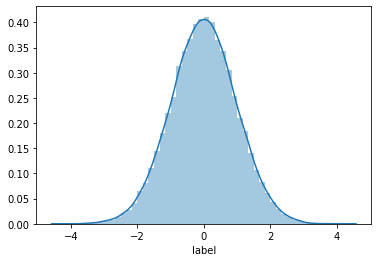

In [73]:
import seaborn as sns
lab = inp_df['label'].dropna()
sns.distplot(lab)

In [66]:
df2_name = data_root + 'Excitatory' + "_C9ALSvsCTRL/APAlog_res_metadata_added.tsv"
inp_df2 = pd.read_csv(df2_name, sep='\t')
inp_df2

,transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name,sig_LFC_PA_Usage
0,AACS,0.006145,0.019492,chr12:125124284:+,chr12:125140928:+,0.261215,4.734204e-02,0.983355,3.376034e-07,+,1,0.983355,6.471593,16644,"chr12,125124284,125140928",1,chr12:AACS:125124284:125140928:+,0.983355
1,AACS,0.006145,0.019492,chr12:125124284:+,chr12:125143316:+,1.641746,4.866807e-52,0.263182,1.246049e-01,+,1,0.263182,0.904465,19032,"chr12,125124284,125143316",1,chr12:AACS:125124284:125143316:+,0.000000
2,AACS,0.006145,0.019492,chr12:125140928:+,chr12:125143316:+,1.380531,8.547748e-46,-0.720173,1.476861e-08,+,1,-0.720173,7.830660,2388,"chr12,125140928,125143316",1,chr12:AACS:125140928:125143316:+,-0.720173
3,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67201672:-,0.936799,7.468705e-06,-0.043726,8.609305e-01,-,-1,0.043726,0.065032,644,"chr15,67201028,67201672",1,chr15:AAGAB:67201028:67201672:-,0.000000
4,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67202710:-,1.470439,7.400884e-14,-1.337591,1.070773e-07,-,-1,1.337591,6.970303,1682,"chr15,67201028,67202710",1,chr15:AAGAB:67201028:67202710:-,1.337591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41174,ZZZ3,1.000000,1.000000,chr1:77564505:-,chr1:77618234:-,-0.321971,2.534728e-02,0.526766,5.576124e-03,-,-1,-0.526766,2.253668,53729,"chr1,77564505,77618234",1,chr1:ZZZ3:77564505:77618234:-,-0.526766
41175,ZZZ3,1.000000,1.000000,chr1:77564505:-,chr1:77629840:-,0.016713,8.988251e-01,-0.225352,2.362558e-01,-,-1,0.225352,0.626618,65335,"chr1,77564505,77629840",1,chr1:ZZZ3:77564505:77629840:-,0.000000
41176,ZZZ3,1.000000,1.000000,chr1:77580998:-,chr1:77618234:-,-0.221592,1.320936e-01,0.933971,6.105239e-06,-,-1,-0.933971,5.214297,37236,"chr1,77580998,77618234",1,chr1:ZZZ3:77580998:77618234:-,-0.933971
41177,ZZZ3,1.000000,1.000000,chr1:77580998:-,chr1:77629840:-,0.117093,3.854144e-01,0.181853,3.789934e-01,-,-1,-0.181853,0.421368,48842,"chr1,77580998,77629840",1,chr1:ZZZ3:77580998:77629840:-,0.000000


In [69]:
import seaborn as sns
lab2 = inp_df2['sig_LFC_PA_Usage'].dropna()
sns.distplot(lab2)

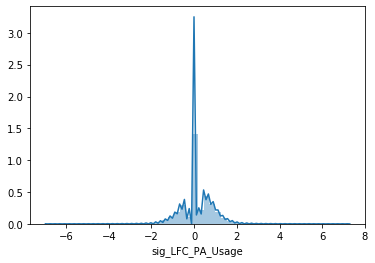

In [71]:
sns.distplot(lab2)

In [80]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')
inp = [[float(i)] for i in range(14)]
output = encoder.fit_transform(inp)

In [13]:
inp

[[0.0],
 [1.0],
 [2.0],
 [3.0],
 [4.0],
 [5.0],
 [6.0],
 [7.0],
 [8.0],
 [9.0],
 [10.0],
 [11.0],
 [12.0],
 [13.0]]

In [81]:
# np.tile(output.toarray()[1],(20,1)).tolist()
[output.toarray()[1]]*2

[array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [116]:
idx = celltypes_order['Excitatory']
inp_df['ct'] = [np.array(output.toarray()[idx], dtype=np.int8)]* inp_df.shape[0]
inp_df

,Unnamed: 0,site_name,seqs,label,ct
0,0,chr12:AACS:125140928:125143316:+,GUGAGGCGGGACAAACUUGUCUUCCUCACACCCAUCUUACUUCCUC...,0.0371,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,chr15:AAGAB:67201672:67202710:-,ACUACAUCAUAAACAUGUCUUUGAAACCCGUCUCCCAUCUUCUAGU...,1.2828,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,chr15:AAGAB:67202710:67217079:-,AUCUAUUAUAGUUCAAUCCCCAGUAAUGCAGAUGGAGGAGGAUUAG...,-0.2141,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,chr2:AAK1:69457997:69461526:-,UUGUAUUCUUAGUAGAGAUGGGGUUUCACCAUGUUGGCCAGGUUGG...,0.0173,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,chr2:AAK1:69457997:69467864:-,AAAAACCCACUUUUUAACAAAUAAUUUUGAUGGGUUAGACAUGUUC...,-0.9525,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...
15779,15779,chr7:ZYX:143382988:143391082:+,AGUCGGGAAUGUGGGGCACGAAUCUUCCCCUCCGGGUCCGUUUUCC...,0.7120,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15780,15780,chr17:ZZEF1:4004475:4006020:-,AAUGAGGGAGUGGCUCCCGACAUUGGCGACAACUCUUUUUCCCUCU...,-0.5428,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15781,15781,chr17:ZZEF1:4004475:4008624:-,GUCACCGAGAACCGUGCCCAGGUGAGGCCUGAGGUCUGGGCAGGGA...,-0.4334,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
15782,15782,chr17:ZZEF1:4006020:4008624:-,GUCACCGAGAACCGUGCCCAGGUGAGGCCUGAGGUCUGGGCAGGGA...,0.1435,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [102]:
celltypes_order

{'AST-FB': 0,
 'AST-PP': 1,
 'Excitatory': 2,
 'IN-PV': 3,
 'IN-SST': 4,
 'IN-VIP': 5,
 'Inhibitory': 6,
 'L2-3': 7,
 'L4': 8,
 'L5-6': 9,
 'L5-6-CC': 10,
 'Microglia': 11,
 'OPC': 12,
 'Oligodendrocytes': 13}

In [117]:
## first get rid of Exci from celltypes list as you already have it in inp_df
acc =inp_df.shape[0]
for celltype in celltypes:
    if celltype != 'Excitatory':
        df_name = data_root + celltype + "_sALSvsCTRL/input_data.tsv"
        df = pd.read_csv(df_name, sep='\t')
        acc += df.shape[0]
        idx = celltypes_order[celltype]
        df['ct'] = [np.array(output.toarray()[idx], dtype=np.float32)] * df.shape[0]
        inp_df = pd.concat([inp_df,df], ignore_index=True)

In [118]:
outname = data_root + "sals_all_seqs_celltypes_input.pkl"
inp_df.to_pickle(outname)

In [91]:
inp_df.shape

(275741, 5)

In [19]:
import pickle, os
import pandas as pd
import random
import numpy as np

def clean_nans(arr):
    """
    takes in the label np.array and then zeros the nan values
    
    """
    arr[np.isnan(arr)] = 0
    out = arr
    return out


def split_data(df):
    """
    takes in the pandas dataframe and split to train, test and valid datasets
    """
    df = df[df['label'].notna()]
    test_index = np.array(random.sample(range(df.shape[0]), int(float(df.shape[0])*0.15)))
    mask = np.zeros(df.shape[0],dtype=bool)
    mask[test_index] = True
    df_test = df[mask]
    df_test.head()
    tmp_df = df[~mask]
    valid_index = np.array(random.sample(range(tmp_df.shape[0]), int(float(tmp_df.shape[0])*0.05)))
    mask = np.zeros(tmp_df.shape[0],dtype=bool)
    mask[valid_index] = True
    df_valid = tmp_df[mask]
    df_train = tmp_df[~mask]
    
    return (df_train, df_valid, df_test)

def change_arr_dtype(arr):
    return arr.astype(np.float32)

def get_np_input_for_model(df):
    # add one hot reps to the df_train
    df['seqs_one_hot'] = df['seqs'].apply(makes_seqs_ready, args=(16000,10))
    df_train_all_num = pd.DataFrame([df['index'],
                                 df['seqs_one_hot'],df['label'],df['celltype']]).T
    df_train_all_num.columns = ['index', 'seqs_one_hot','label','celltype']
    # make the np array of data
    idx = np.array(df_train_all_num['index'].values, dtype=np.float32)
    seqs = np.array(df_train_all_num['seqs_one_hot'].values)
    labels = np.array(df_train_all_num['label'].values, dtype=np.float32)
    celltype = df_train_all_num['celltype'].values
    df_train_all_num_numpy = pd.DataFrame([idx,seqs,labels,celltype]).T.to_numpy()
    
    return df_train_all_num_numpy


def makes_seqs_ready(seq,max_len,left_pad_max):
    """
    takes in the sequence, max len and max left pad
    and returns the one hot representation of sequence with maximum pad
    """
    if len(seq) < max_len:
        diff = max_len - len(seq)
        lp = random.randint(0, left_pad_max)
        lp = min(lp, diff)
        seq = get_1h_seq(
            "N" * (lp) + str(seq) + "N" * (max_len - len(seq) - lp)
        )
    else:
        seq = get_1h_seq(str(seq))
    seq = np.array(seq, dtype=np.float32).swapaxes(0, 1)
    
    return seq

def get_1h_seq(seq):
    """
    This is a simple code to get one-hot representaton of the
    senquences.
    --------------
    Arguments:
    seq: RNA sequence in fasta format
    """
    nt_code = {
        "N": [0, 0, 0, 0],
        "A": [1, 0, 0, 0],
        "C": [0, 1, 0, 0],
        "G": [0, 0, 1, 0],
        "U": [0, 0, 0, 1],
    }

    seq_1h = [nt_code[nt] for nt in seq]
    return np.array(seq_1h)


In [382]:
def makit_nparr(lst):
    lst = list(lst)
    print(lst)
    arr = np.array(lst, dtype=np.float32)

['[', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '1', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ' ', '0', '.', ']']


ValueError: could not convert string to float: '['

In [486]:
# ## read in the all_seqs_all_ct dataframe and prepare numpy input
# dtype_in = {}
# input_data = pd.read_csv(outname, sep='\t')
# input_data = input_data.iloc[:,1:]
# input_data.columns = ['index','site_name', 'seqs','label','celltype']
# input_data['index'] = input_data.index.values
# input_data
##### I had problem with reading the pd.dataframe of the input! it reads in the celltype arrays as string
##### to avoid this you should pass in the dtype dictionary to your pd.read_csv, for now lets skip it

In [20]:
inp_df.columns = ['index','site_name', 'seqs','label','celltype']
df_train, df_valid, df_test = split_data(inp_df)

df_valid.columns = ['index','site_name', 'seqs','label','celltype']
df_valid = get_np_input_for_model(df_valid)


df_train.columns = ['index','site_name', 'seqs','label','celltype']
df_train = get_np_input_for_model(df_train)

df_test.columns = ['index','site_name', 'seqs','label','celltype']
df_test = get_np_input_for_model(df_test)

In [21]:
np.save('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/valid_data', df_valid)
np.save('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/train_data', df_train)
np.save('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/test_data', df_test)

In [509]:
print(df_valid.shape)
print(df_test.shape)

(11715, 4)
(41350, 4)


In [ ]:
np.save('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/valid_data', df_valid)
np.save('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/train_data', df_train)
np.save('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/test_data', df_test)

In [29]:
np.save('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/tst_train_data', df_valid[1:33])

In [30]:
df_train.shape

(242568, 4)

## Lets get positive control
## basically do motif analysis on seqs that are lengthened (positive LFC) 

In [31]:
exc_res = pd.read_csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/APAlog_res_metadata_added.tsv', sep='\t')
exc_res

,transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name,sig_LFC_PA_Usage
0,AACS,0.006145,0.019492,chr12:125124284:+,chr12:125140928:+,0.261215,4.734204e-02,0.983355,3.376034e-07,+,1,0.983355,6.471593,16644,"chr12,125124284,125140928",1,chr12:AACS:125124284:125140928:+,0.983355
1,AACS,0.006145,0.019492,chr12:125124284:+,chr12:125143316:+,1.641746,4.866807e-52,0.263182,1.246049e-01,+,1,0.263182,0.904465,19032,"chr12,125124284,125143316",1,chr12:AACS:125124284:125143316:+,0.000000
2,AACS,0.006145,0.019492,chr12:125140928:+,chr12:125143316:+,1.380531,8.547748e-46,-0.720173,1.476861e-08,+,1,-0.720173,7.830660,2388,"chr12,125140928,125143316",1,chr12:AACS:125140928:125143316:+,-0.720173
3,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67201672:-,0.936799,7.468705e-06,-0.043726,8.609305e-01,-,-1,0.043726,0.065032,644,"chr15,67201028,67201672",1,chr15:AAGAB:67201028:67201672:-,0.000000
4,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67202710:-,1.470439,7.400884e-14,-1.337591,1.070773e-07,-,-1,1.337591,6.970303,1682,"chr15,67201028,67202710",1,chr15:AAGAB:67201028:67202710:-,1.337591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41174,ZZZ3,1.000000,1.000000,chr1:77564505:-,chr1:77618234:-,-0.321971,2.534728e-02,0.526766,5.576124e-03,-,-1,-0.526766,2.253668,53729,"chr1,77564505,77618234",1,chr1:ZZZ3:77564505:77618234:-,-0.526766
41175,ZZZ3,1.000000,1.000000,chr1:77564505:-,chr1:77629840:-,0.016713,8.988251e-01,-0.225352,2.362558e-01,-,-1,0.225352,0.626618,65335,"chr1,77564505,77629840",1,chr1:ZZZ3:77564505:77629840:-,0.000000
41176,ZZZ3,1.000000,1.000000,chr1:77580998:-,chr1:77618234:-,-0.221592,1.320936e-01,0.933971,6.105239e-06,-,-1,-0.933971,5.214297,37236,"chr1,77580998,77618234",1,chr1:ZZZ3:77580998:77618234:-,-0.933971
41177,ZZZ3,1.000000,1.000000,chr1:77580998:-,chr1:77629840:-,0.117093,3.854144e-01,0.181853,3.789934e-01,-,-1,-0.181853,0.421368,48842,"chr1,77580998,77629840",1,chr1:ZZZ3:77580998:77629840:-,0.000000


In [32]:
exc_res_lengthened = exc_res[exc_res['sig_LFC_PA_Usage'] > 0]
exc_res_lengthened

,transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name,sig_LFC_PA_Usage
0,AACS,0.006145,0.019492,chr12:125124284:+,chr12:125140928:+,0.261215,4.734204e-02,0.983355,3.376034e-07,+,1,0.983355,6.471593,16644,"chr12,125124284,125140928",1,chr12:AACS:125124284:125140928:+,0.983355
4,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67202710:-,1.470439,7.400884e-14,-1.337591,1.070773e-07,-,-1,1.337591,6.970303,1682,"chr15,67201028,67202710",1,chr15:AAGAB:67201028:67202710:-,1.337591
5,AAGAB,0.000253,0.001115,chr15:67201028:-,chr15:67217079:-,1.098249,8.045112e-08,-1.226330,3.590218e-06,-,-1,1.226330,5.444879,16051,"chr15,67201028,67217079",1,chr15:AAGAB:67201028:67217079:-,1.226330
6,AAGAB,0.000253,0.001115,chr15:67201672:-,chr15:67202710:-,0.533640,1.343992e-04,-1.293865,1.237304e-11,-,-1,1.293865,10.907524,1038,"chr15,67201672,67202710",1,chr15:AAGAB:67201672:67202710:-,1.293865
7,AAGAB,0.000253,0.001115,chr15:67201672:-,chr15:67217079:-,0.161450,2.848487e-01,-1.182604,1.250607e-08,-,-1,1.182604,7.902879,15407,"chr15,67201672,67217079",1,chr15:AAGAB:67201672:67217079:-,1.182604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41170,ZZZ3,1.000000,1.000000,chr1:77562475:-,chr1:77580998:-,1.235521,2.309093e-09,-1.937261,1.751085e-14,-,-1,1.937261,13.756693,18523,"chr1,77562475,77580998",1,chr1:ZZZ3:77562475:77580998:-,1.937261
41171,ZZZ3,1.000000,1.000000,chr1:77562475:-,chr1:77618234:-,1.013929,1.827069e-06,-1.003291,3.643041e-05,-,-1,1.003291,4.438536,55759,"chr1,77562475,77618234",1,chr1:ZZZ3:77562475:77618234:-,1.003291
41172,ZZZ3,1.000000,1.000000,chr1:77562475:-,chr1:77629840:-,1.352614,3.506398e-11,-1.755409,5.237627e-13,-,-1,1.755409,12.280865,67365,"chr1,77562475,77629840",1,chr1:ZZZ3:77562475:77629840:-,1.755409
41173,ZZZ3,1.000000,1.000000,chr1:77564505:-,chr1:77580998:-,-0.100379,4.586096e-01,-0.407205,4.407777e-02,-,-1,0.407205,1.355780,16493,"chr1,77564505,77580998",1,chr1:ZZZ3:77564505:77580998:-,0.407205


In [33]:
exc_res_lengthened.shape

(15743, 18)

In [62]:
out_name = "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/Exc_lengthened_PAs.fa"
output_handle = open(out_name, 'w')
inp_fa = "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/switch_DNA_sequence.fa"
inp_fa = SeqIO.parse(inp_fa, "fasta")
Exc_lengthened_RNAs = {}
for rec in inp_fa:
    if rec.id in list(exc_res_lengthened['switch_name']):
        strand = rec.id .split(':')[-1]
        if strand == '+':
            seq = transcribe_positive_strand(str(rec.seq))
        else:
            seq = transcribe_negative_strand(str(rec.seq))
        if len(seq) > 7000:
            Exc_lengthened_RNAs[rec.id] = seq
               

In [63]:
Exc_lengthened_RNAs_df = pd.DataFrame([list(Exc_lengthened_RNAs.keys()), list(Exc_lengthened_RNAs.values())]).T

In [64]:
Exc_lengthened_RNAs_df.to_csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/Exc_lengthened_PAs.tsv',
                              sep='\t', index=False)

In [65]:
SeqIO.convert('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/Exc_lengthened_PAs.tsv',
              'tab', '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/Exc_lengthened_PAs_seq.fa', 'fasta')


2186